# Demonstrate examples for collaboration with novo nordisk

In [29]:
from data_causl.utils import *
from data_causl.data import *
from frengression import *

device = torch.device('cpu')
from CausalEGM import *

import numpy as np
import pickle
import os
from tqdm import tqdm
import src.exp_utils as exp_utils
import torch.nn as nn

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Helper function for MMD
def mmd_rbf(x, y, sigma=1.0):
    """Compute MMD between two distributions using RBF kernel."""
    pairwise_sq_dists = squareform(pdist(np.vstack([x, y]), 'sqeuclidean'))
    K = np.exp(-pairwise_sq_dists / (2 * sigma ** 2))
    K_xx = K[:len(x), :len(x)]
    K_xy = K[:len(x), len(x):]
    K_yy = K[len(x):, len(x):]
    mmd = np.mean(K_xx) - 2 * np.mean(K_xy) + np.mean(K_yy)
    return mmd


np.random.seed(42)

nI = 2
nX = 2
nO = 2
nS= 2
p = nI+nX+nO+nS
ate = 4
beta_cov = 0
strength_instr = 0
strength_conf = 0
strength_outcome = 1
binary_intervention=True

In [30]:
df_tr = generate_data_causl(n=1000, nI =nI, nX= nX, nO = nO, nS = nS, ate = ate, beta_cov = beta_cov, strength_instr = strength_instr, strength_conf = strength_conf, strength_outcome =strength_outcome, binary_intervention=binary_intervention)
z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1)
y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

## specify causal margin

In [ ]:
np.random.seed(42)
model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = binary_intervention)
model.train_xz(x_tr, z_tr, num_iters=1000, lr=1e-4, print_every_iter=200)
model.train_y(x_tr, z_tr, y_tr, num_iters=1000, lr=1e-4, print_every_iter=200, tol=0.01)

Epoch 1: loss 2.6746, loss1 2.8219, loss2 0.2945
Epoch 200: loss 2.1552, loss1 3.1431, loss2 1.9758
Epoch 400: loss 2.0100, loss1 3.7370, loss2 3.4538
Epoch 600: loss 2.0106, loss1 3.9047, loss2 3.7881
Epoch 800: loss 2.0216, loss1 3.9447, loss2 3.8463
Epoch 1000: loss 2.0219, loss1 3.9230, loss2 3.8022
Epoch 1: loss 3.2469,	loss_y 2.4396, 2.4704, 0.0616,	loss_eta 0.8072, 0.8415, 0.0686
Epoch 200: loss 1.9519,	loss_y 1.3969, 1.7899, 0.7859,	loss_eta 0.5549, 1.0886, 1.0674
Epoch 400: loss 0.9582,	loss_y 0.3869, 0.9320, 1.0901,	loss_eta 0.5713, 1.1768, 1.2110
Epoch 600: loss 0.9193,	loss_y 0.3611, 0.7096, 0.6969,	loss_eta 0.5582, 1.1297, 1.1429
Epoch 800: loss 0.8311,	loss_y 0.3175, 0.6795, 0.7240,	loss_eta 0.5136, 1.0744, 1.1215
Epoch 1000: loss 0.8823,	loss_y 0.3507, 0.6790, 0.6565,	loss_eta 0.5316, 1.0916, 1.1200


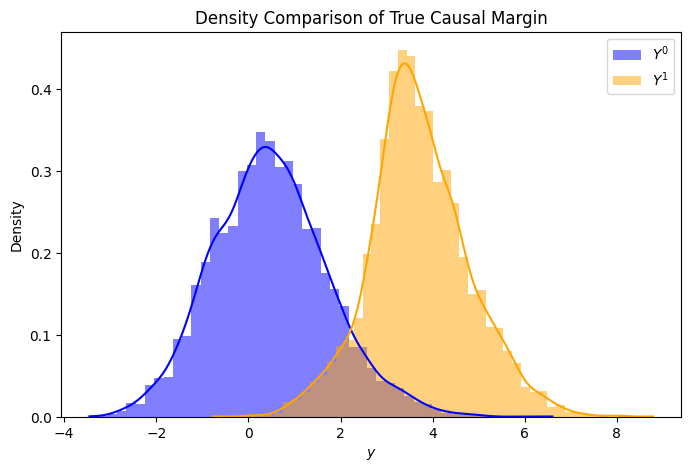

In [32]:
# Sample causal margins
x0_samples = model.sample_causal_margin(x=torch.tensor([[0]], dtype=torch.int32), sample_size=6000).numpy().flatten()
x1_samples = model.sample_causal_margin(x=torch.tensor([[1]], dtype=torch.int32), sample_size=6000).numpy().flatten()

# Plot histograms and KDE
plt.figure(figsize=(8, 5))

# Histogram for x0_samples
sns.histplot(x0_samples, kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(x1_samples, kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
# plt.axvline(max(x0_samples), color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
# plt.axvline(max(x1_samples), color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title("Density Comparison of True Causal Margin")
plt.legend()
plt.show()


In [35]:
sampled_x,sampled_y,sampled_z = model.sample_joint(sample_size=6000)
print('Diff-in-means: ', sampled_y[sampled_x==1].mean()-sampled_y[sampled_x==0].mean())
print('Proportion of sampled treated: ', (sampled_x==1).sum()/sampled_x.shape[0])
print('Proportion of true treated: ', (x_tr==1).sum()/x_tr.shape[0])

Diff-in-means:  tensor(3.4698)
Proportion of sampled treated:  tensor(0.4882)
Proportion of true treated:  tensor(0.4980)


In [36]:
class SpecifiedCausalMargin(nn.Module):
    def __init__(self, ate,x_dim):
        super().__init__()
        self.ate = ate
        self.x_dim = x_dim

    def forward(self, x_eta):
        # If 'eta' is truly separate, might need to handle that carefully
        x = x_eta[:, :self.x_dim]
        eta = x_eta[:, self.x_dim:]
        return self.ate * x + eta


In [37]:
margin_module = SpecifiedCausalMargin(ate=5, x_dim = x_tr.shape[1])
model.specify_causal(causal_margin=margin_module)

sampled_x,sampled_y,sampled_z = model.sample_joint(sample_size=10000)
print('Diff-in-means: ', sampled_y[sampled_x==1].mean()-sampled_y[sampled_x==0].mean())
print('Proportion of sampled treated: ', (sampled_x==1).sum()/sampled_x.shape[0])
print('Proportion of true treated: ', (x_tr==1).sum()/x_tr.shape[0])

Diff-in-means:  tensor(4.7594)
Proportion of sampled treated:  tensor(0.4918)
Proportion of true treated:  tensor(0.4980)


In [38]:
margin_module = SpecifiedCausalMargin(ate=0, x_dim = x_tr.shape[1])
model.specify_causal(causal_margin=margin_module)

sampled_x,sampled_y,sampled_z = model.sample_joint(sample_size=50000)
print('Diff-in-means: ', sampled_y[sampled_x==1].mean()-sampled_y[sampled_x==0].mean())
print('Proportion of sampled treated: ', (sampled_x==1).sum()/sampled_x.shape[0])
print('Proportion of true treated: ', (x_tr==1).sum()/x_tr.shape[0])

Diff-in-means:  tensor(-0.2244)
Proportion of sampled treated:  tensor(0.4822)
Proportion of true treated:  tensor(0.4980)


## With heterogeneity

In [42]:
nI = 2
nX = 2
nO = 2
nS= 2
p = nI+nX+nO+nS
ate = 4
beta_cov = 0
strength_instr = 0
strength_conf = 0
strength_outcome = 0.5
binary_intervention=True

In [43]:
df_tr = generate_data_causl(n=1000, nI =nI, nX= nX, nO = nO, nS = nS, ate = ate, beta_cov = beta_cov, strength_instr = strength_instr, strength_conf = strength_conf, strength_outcome =strength_outcome, binary_intervention=binary_intervention)
z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1)
y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

In [44]:
model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = binary_intervention)
model.train_xz(x_tr, z_tr, num_iters=1000, lr=1e-4, print_every_iter=200)
model.train_y(x_tr, z_tr, y_tr, num_iters=1000, lr=1e-4, print_every_iter=200)

Epoch 1: loss 2.6531, loss1 2.7930, loss2 0.2798
Epoch 200: loss 2.1322, loss1 3.1576, loss2 2.0508
Epoch 400: loss 2.0517, loss1 3.7466, loss2 3.3898
Epoch 600: loss 2.0178, loss1 3.8853, loss2 3.7351
Epoch 800: loss 1.9828, loss1 3.8961, loss2 3.8266
Epoch 1000: loss 2.0178, loss1 3.9056, loss2 3.7755
Epoch 1: loss 3.0687,	loss_y 2.2730, 2.2974, 0.0489,	loss_eta 0.7958, 0.8280, 0.0644
Epoch 200: loss 1.6298,	loss_y 1.0549, 1.5507, 0.9917,	loss_eta 0.5749, 1.0957, 1.0417
Epoch 400: loss 1.1087,	loss_y 0.5779, 1.1730, 1.1902,	loss_eta 0.5308, 1.0869, 1.1121
Epoch 600: loss 1.1312,	loss_y 0.5692, 1.1402, 1.1420,	loss_eta 0.5621, 1.1114, 1.0986
Epoch 800: loss 1.1094,	loss_y 0.5798, 1.1217, 1.0838,	loss_eta 0.5296, 1.1028, 1.1464
Epoch 1000: loss 1.0819,	loss_y 0.5238, 1.0443, 1.0411,	loss_eta 0.5581, 1.1434, 1.1706


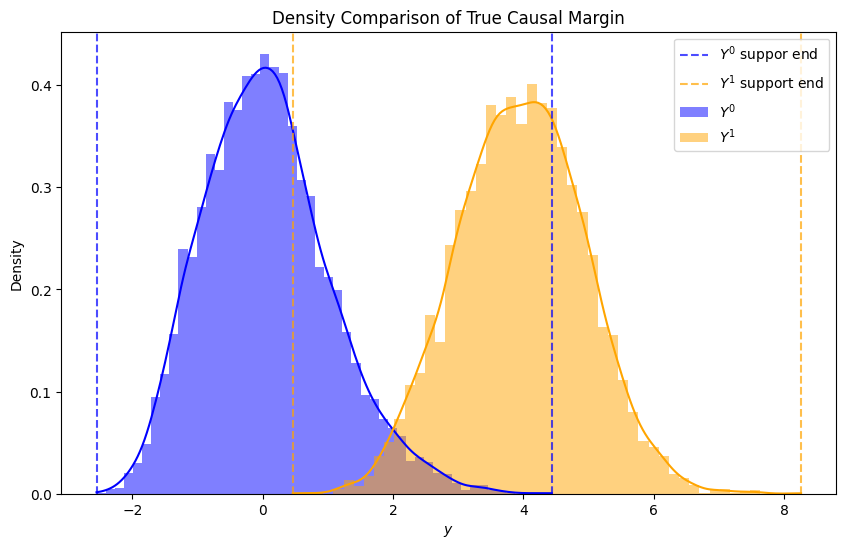

In [45]:
# Sample causal margins
x0_samples = model.sample_causal_margin(x=torch.tensor([[0]], dtype=torch.int32), sample_size=6000).numpy().flatten()
x1_samples = model.sample_causal_margin(x=torch.tensor([[1]], dtype=torch.int32), sample_size=6000).numpy().flatten()

# Plot histograms and KDE
plt.figure(figsize=(10, 6))

# Histogram for x0_samples
sns.histplot(x0_samples, kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(x1_samples, kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
plt.axvline(max(x0_samples), color='blue', linestyle='--', alpha=0.7)
plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
plt.axvline(max(x1_samples), color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title("Density Comparison of True Causal Margin")
plt.legend()
plt.show()


In [46]:
sampled_x,sampled_y,sampled_z = model.sample_joint(sample_size=1000)
print('Diff-in-means: ', sampled_y[sampled_x==1].mean()-sampled_y[sampled_x==0].mean())
print('Proportion of sampled treated: ', (sampled_x==1).sum()/sampled_x.shape[0])
print('Proportion of true treated: ', (x_tr==1).sum()/x_tr.shape[0])

Diff-in-means:  tensor(3.8505)
Proportion of sampled treated:  tensor(0.5260)
Proportion of true treated:  tensor(0.5000)


In [47]:
class SpecifiedCausalMargin(nn.Module):
    def __init__(self, ate,x_dim):
        super().__init__()
        self.ate = ate  # or self.register_buffer('eta', torch.tensor(eta))
        self.x_dim = x_dim

    def forward(self, x_eta):
        # If 'eta' is truly separate, might need to handle that carefully
        x = x_eta[:, :self.x_dim]
        eta = x_eta[:, self.x_dim:]
        return self.ate * x + eta


In [48]:
margin_module = SpecifiedCausalMargin(ate=5, x_dim = x_tr.shape[1])
model.specify_causal(causal_margin=margin_module)
# model.train_y(x_tr, z_tr, y_tr, num_iters=1000, lr=1e-4, print_every_iter=200)

sampled_x,sampled_y,sampled_z = model.sample_joint(sample_size=2000)
print('Diff-in-means: ', sampled_y[sampled_x==1].mean()-sampled_y[sampled_x==0].mean())
print('Proportion of sampled treated: ', (sampled_x==1).sum()/sampled_x.shape[0])
print('Proportion of true treated: ', (x_tr==1).sum()/x_tr.shape[0])

Diff-in-means:  tensor(4.9540)
Proportion of sampled treated:  tensor(0.4975)
Proportion of true treated:  tensor(0.5000)


In [49]:
margin_module = SpecifiedCausalMargin(ate=0, x_dim = x_tr.shape[1])
model.specify_causal(causal_margin=margin_module)
# model.train_y(x_tr, z_tr, y_tr, num_iters=100000, lr=1e-4, print_every_iter=1000)
sampled_x,sampled_y,sampled_z = model.sample_joint(sample_size=2000)
print('Diff-in-means: ', sampled_y[sampled_x==1].mean()-sampled_y[sampled_x==0].mean())
print('Proportion of sampled treated: ', (sampled_x==1).sum()/sampled_x.shape[0])
print('Proportion of true treated: ', (x_tr==1).sum()/x_tr.shape[0])

Diff-in-means:  tensor(-0.1258)
Proportion of sampled treated:  tensor(0.5165)
Proportion of true treated:  tensor(0.5000)
